In [ ]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, distances, n_ants, n_iterations, decay=0.5, alpha=1, beta=5, Q=100, n_best=None, P=0.5, t_max=100000000, t_min=1, p_best=0.5, timelimit = 60):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1
        """
        self.distances = distances
        # Set the pheromones in T(0) to an arbitrarily high value. Afterwards, they will be reduced to the new t_max.
        self.pheromone = np.full(self.distances.shape, 1000000) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.t_max = t_max
        self.t_min = t_min
        self.p_best = p_best
         # keeps track of length shortest path
        self.history = [] #np.zeros(n_iterations)
        self.timestamps = []

        self.timelimit = timelimit
        
    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        i = 0
        while time.time() - time_start < self.timelimit:

            # Update t_max and t_min
            all_paths = self.gen_all_paths()
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path
                path, shortest_dist = all_time_shortest_path
                self.t_max = 1 / (self.decay * shortest_dist)
                self.t_min = self.t_max * (1 - self.p_best * len(self.distances)) * (len(self.distances / 2) - 1) * self.p_best * len(self.distances)
                if (self.t_min > self.t_max):
                    self.t_min = self.t_max

            # Update all edges to never be higher than t_max or lower than t_min
            a_iter = 0
            while a_iter < self.distances.shape[0]:
                b_iter = 0
                while b_iter < self.distances.shape[1]:
                    if self.pheromone[a_iter][b_iter] > self.t_max:
                        self.pheromone[a_iter][b_iter] = self.t_max
                    elif self.pheromone[a_iter][b_iter] < self.t_min:
                        self.pheromone[a_iter][b_iter] = self.t_min
                    b_iter = b_iter + 1
                a_iter = a_iter + 1
                
            # Spread pheromone
            self.pheromone * self.decay  
            self.spread_pheronome(all_paths, shortest_path=shortest_path, i=i, all_time_shortest_path = all_time_shortest_path)
            # keep track of length shortest path
            self.timestamps.append(time.time() - time_start)
            self.history.append(all_time_shortest_path[1])
            i = i + 1
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, shortest_path, i, all_time_shortest_path):

        # Changes the frequency of applying the global best based on the progress of iterations
        iteration_t = i
        if iteration_t < 25:
            global_frequency = 26
        elif iteration_t < 75:
            global_frequency = 5
        elif iteration_t < 125:
            global_frequency = 3
        elif iteration_t < 250:
            global_frequency = 2
        else:
            global_frequency = 1

        # Use global best when appropriate
        if (iteration_t != 0 and(iteration_t / global_frequency).is_integer() == True):
            path, dist = all_time_shortest_path
            for move in path:
                self.pheromone[move] += self.Q/dist 

        # Otherwise, use iteration best
        else:
            sorted_paths = sorted(all_paths, key=lambda x: x[1])
            for path, dist in sorted_paths[:1]:
                for move in path:
                    self.pheromone[move] += self.Q/dist

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set() # tabu list
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0 # tabu list
        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)
        norm_row = row / row.sum() 
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

In [ ]:
# Mount Google Drive to fetch data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Natural computing/rowan/ant_colony.py"

'/content/drive/My Drive/Natural computing/rowan/ant_colony.py'


In [ ]:
!cp "/content/drive/My Drive/Natural computing/rowan/ant_colony.py" . # from https://github.com/Akavall/AntColonyOptimization/blob/master/ant_colony.py

In [ ]:
!pip install tsplib95

In [ ]:
import tsplib95
import networkx
import numpy as np
import time
import matplotlib.pyplot as plt

from numpy import savetxt
from numpy import loadtxt


In [ ]:
 # Change this path to be appropriate to the Google Drive location of your TSP problems
  TSP_PATH  = "/content/drive/My Drive/Natural computing/tsp/"

In [ ]:
def load_tsp(tsp_name): 
  problem = tsplib95.load(TSP_PATH+ tsp_name + ".tsp")
  # convert into a networkx.Graph
  graph = problem.get_graph()
  # convert into a numpy distance matrix
  distance_matrix = np.asarray(networkx.to_numpy_matrix(graph))
  # Change diagonal to np.inf, this is needed in order to use ant_colony.py
  np.fill_diagonal(distance_matrix,  np.inf)
  return distance_matrix

def show_history(history, timestamps):
  '''
  history (numpy.array): Array with history of shortest path length found
  '''
  plt.figure()
  plt.plot(timestamps, history)
  plt.xlabel("Time Elapsed")
  plt.ylabel("Distance")

def compare_history(aco_instances, labels):
  '''
  Example:
    aco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit)
    meaco = AntColony(tsp, n_ants=n_ants, timelimit=timelimit, MEACO = True)
    compare_history(aco_instances=[aco,meaco], labels=["ACO","MEACO"])
  '''
  plt.figure()
  for i, aco in enumerate(aco_instances):
    plt.plot(aco.timestamps, aco.history, marker='.', label=labels[i])
  plt.legend()
  plt.xlabel("time elapsed")
  plt.ylabel("Distance")
  

In [ ]:
# Change this to be the name of your TSP problem, saved in your Google Drive
tsp = load_tsp("oliver30")

#ulysses16 oliver30 st70 and eil101 use these timelimits respectively: 60s 180s 300s and 720s

Done in 180.01s
shortest_path: [1, 2, 30, 29, 28, 27, 24, 26, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
Length path: 420.0
Done in 180.04s
shortest_path: [1, 2, 30, 29, 28, 27, 24, 26, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
Length path: 420.0
Done in 180.06s
shortest_path: [1, 3, 2, 30, 29, 28, 27, 24, 26, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
Length path: 420.0
Done in 180.05s
shortest_path: [1, 3, 24, 26, 30, 29, 28, 27, 22, 23, 25, 19, 20, 21, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 2]
Length path: 430.0
Done in 180.04s
shortest_path: [1, 2, 30, 29, 28, 27, 24, 26, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3]
Length path: 420.0
Done in 180.02s
shortest_path: [1, 3, 2, 30, 29, 28, 27, 24, 26, 25, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4]
Length path: 420.0
Done in 180.02s
shortest_pat

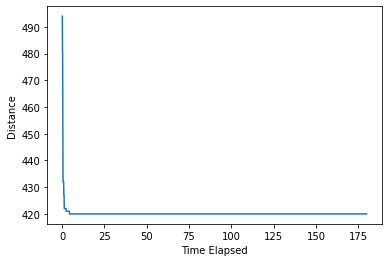

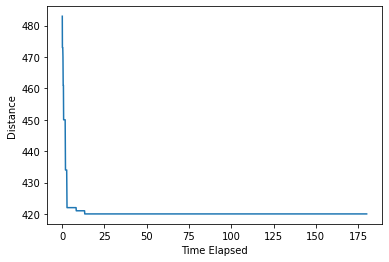

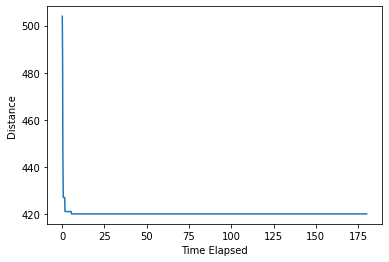

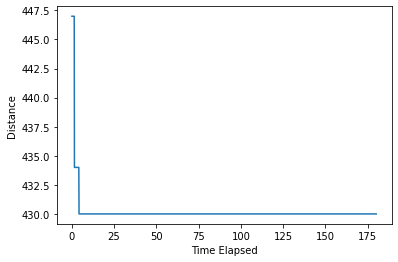

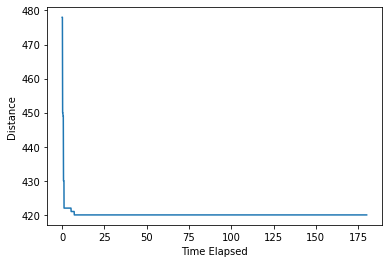

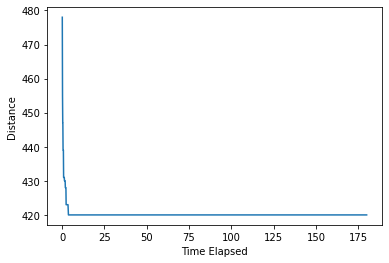

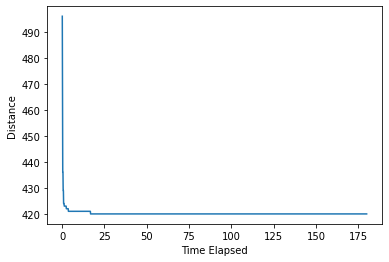

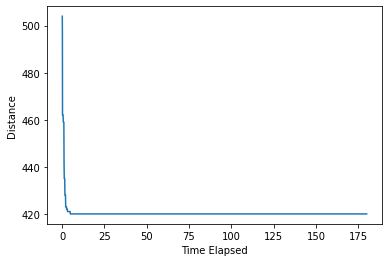

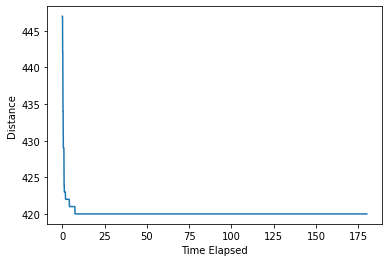

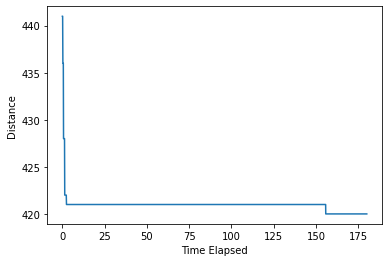

In [ ]:
all_history = []
all_timestamps = [] 

# Run the algorithm, get data.
for i in range(10):
  # n_ants should be equal to the amount of cities in the TSP.
  # Suggestions for p_best:  p_best=0.0005  p_best=0.005  p_best=0.05  p_best=0.5.  
  # p_best=0.05 came out best overall in the paper, as it was the most optimal or the next best option every time.
  ant_colony = AntColony(tsp, n_ants=30, n_iterations=100, n_best=1, p_best=0.05, timelimit = 180)

  time_start = time.time()
  shortest_path, length = ant_colony.run()
  time_end = time.time()

  all_history.append(ant_colony.history)
  all_timestamps.append(ant_colony.timestamps)

  print("Done in %.2fs" % (time_end - time_start,))
  shortest_path = [edge[0]+1 for edge in shortest_path]
  print ("shortest_path: {}".format(shortest_path))
  print("Length path: {}".format(length))
  show_history(ant_colony.history, ant_colony.timestamps)

In [ ]:

# Save the data of all runs to csv files.
pad = len(max(all_history, key=len))

to_save_history =  np.array([i + [0]*(pad-len(i)) for i in all_history])
to_save_timestamps = np.array([i + [0]*(pad-len(i)) for i in all_timestamps])

savetxt('oliver30MINMAX_history_v2.csv', to_save_history, delimiter=',')
savetxt('oliverMINMAX_timestamps_v2.csv', to_save_timestamps, delimiter=',')